# Data visualization

In [28]:
import numpy as np
import pandas as pd
import re
from underthesea import word_tokenize
from pyvi import ViTokenizer
import itertools
import string
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
# get data
df = pd.read_csv('data/public_train.csv').append(pd.read_excel('data/warmup_training_dataset.xlsx'))
print(df.shape)
df.head()

(5172, 8)


,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
0,1.0,389c669730cb6c54314a46be785cea42,"THĂNG CẤP BẬC HÀM ĐỐI VỚI 2 CÁN BỘ, CHIẾN SỸ H...",1585945439,19477,378,173.0,0.0
1,2.0,775baa6d037b6d359b229a656eaeaf08,<URL>,1588939166.0,11,5,3,0.0
2,3.0,b9f3394d2aff86d85974f5040c401f08,TƯ VẤN MÙA THI: Cách nộp hồ sơ để trúng tuyển ...,1591405213,48,5,19.0,0.0
3,4.0,808e278b22ec6b96f2faf7447d10cd8e,Cơ quan Cạnh tranh và Thị trường Anh quyết địn...,1592023613,3,0,0.0,0.0
4,5.0,f81bdd6d8be4c5f64bb664214e47aced,Thêm 7 ca tại Quảng Nam liên quan đến hành khá...,1583737358,775,0,54.0,0.0


In [30]:
# check null value in data
df.isnull().sum()

id                    0
user_name             0
post_message          1
timestamp_post      164
num_like_post       146
num_comment_post     14
num_share_post      929
label                 0
dtype: int64

In [31]:
# convert unknown record to 0 value
df.iloc[:, 4:7] = df.iloc[:, 4:7].replace('unknown', 0)

# cast from Dtype object to int64 
for i in range(3, 7):
  df.iloc[:, i] = pd.to_numeric(df.iloc[:, i], errors='coerce', downcast='integer')
  
# convert timestamp to date format
df['timestamp_post'] = pd.to_datetime(df['timestamp_post'], unit='s', errors='coerce')

In [32]:
# check duplicate data
df[df.duplicated('post_message')]

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
150,151.0,dd35242704071b7ddf90a8ee90055ec4,<URL>,2020-05-08 14:20:22,87.0,4.0,1.0,0.0
175,176.0,79c2d500763b7f14f2631a8ab6a71ea4,<URL>,2020-05-08 06:02:39,NaN,0.0,NaN,0.0
178,179.0,59fb67d9b2bd2b380529562035b3bab4,<URL>,2020-04-23 08:55:07,3.0,2.0,NaN,0.0
197,198.0,ae7c1d8434b0629a83958eac387e7424,Cơ hội có 1-0-2 để cùng nhau xây dựng những cô...,2020-03-15 08:47:29,2898.0,50.0,142.0,0.0
454,455.0,654d291ef3011072e7980e89293fbdac,<URL>,2020-06-20 14:35:24,4.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...
769,769.0,297491051505678016.0,"“Giữa đại dịch virus corona, Thủ tướng Nhật Ab...",2020-05-13 05:19:05,126.0,7.0,17.0,0.0
776,776.0,896764849329199104.0,Bí thư Vương Đình Huệ cho biết Hà Nội đặt mục ...,2020-05-05 14:35:42,5.0,0.0,2.0,0.0
784,784.0,-6167405391948957696.0,TAND Cấp cao tại TP HCM đã kháng nghị Giám đốc...,2020-06-05 14:32:21,49.0,3.0,10.0,0.0
788,788.0,3380755255845678080.0,"Hướng về Hà Nội ❤\n\nSáng nay 7-3, Ban Chỉ đạo...",2020-03-07 03:51:33,30.0,4.0,6.0,0.0


In [33]:
# remove null, duplicate text content record and change dtype of num_like, comment, share feature to int64
df = df.dropna(subset=['post_message'])
df['timestamp_post'] = df['timestamp_post'].fillna(pd.Timestamp(0)) # empty timestamp
df = df.fillna(0)
df = df.drop_duplicates(subset='post_message', keep='first')
df.iloc[:, 4:7] = df.iloc[:, 4:7].astype('int64')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4868 entries, 0 to 799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                4868 non-null   float64       
 1   user_name         4868 non-null   object        
 2   post_message      4868 non-null   object        
 3   timestamp_post    4868 non-null   datetime64[ns]
 4   num_like_post     4868 non-null   int64         
 5   num_comment_post  4868 non-null   int64         
 6   num_share_post    4868 non-null   int64         
 7   label             4868 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 342.3+ KB


# Visualization

Số lượng tin trong dữ liệu: 4868 

label
0.0    4050
1.0     818
dtype: int64 



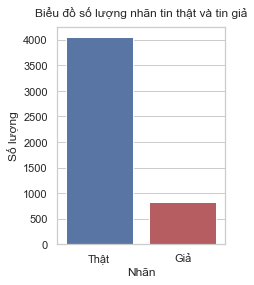

In [35]:
# Count of each label
label_count = df.value_counts('label')

sns.set_theme(style="whitegrid")
plt.figure(figsize=(3, 4))
sns.barplot(x=['Thật', 'Giả'], y=label_count, palette=['b', 'r'])
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.title('Biểu đồ số lượng nhãn tin thật và tin giả', y=1.02) # y = space from graph
print('Số lượng tin trong dữ liệu:', len(df['label']), '\n')
print(label_count, '\n')

In [36]:
from vncorenlp import VnCoreNLP
rdrsegmenter = VnCoreNLP("data/vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

# get stopwords list
f = open('data/vietnamese-stopwords-dash.txt', 'r', encoding="utf8")
stopwords = f.read().split('\n')

# remove stopwords in news text
def clean_stopwords(text_list):
  ''' sent_list: already tokenized text in list type
  '''
  clean_text = []
  for word in text_list:
    if word not in stopwords:
      clean_text.append()
  return clean_text

def tokenize(text):
  text = text.translate(str.maketrans('', '', string.punctuation)) # clean punctuation
  #text = word_tokenize(text.lower(), format="text") #tokenize, word segment
  #return clean_stopwords(text.split())
  text = rdrsegmenter.tokenize(text.lower())
  return text[0]

In [37]:
true_news = [tokenize(n) for n in df[df['label'] == 0]['post_message']]
fake_news = [tokenize(n) for n in df[df['label'] == 1]['post_message']]

Text(0.5, 1.0, 'Biểu đồ số lượng từ trong tin thật và giả')

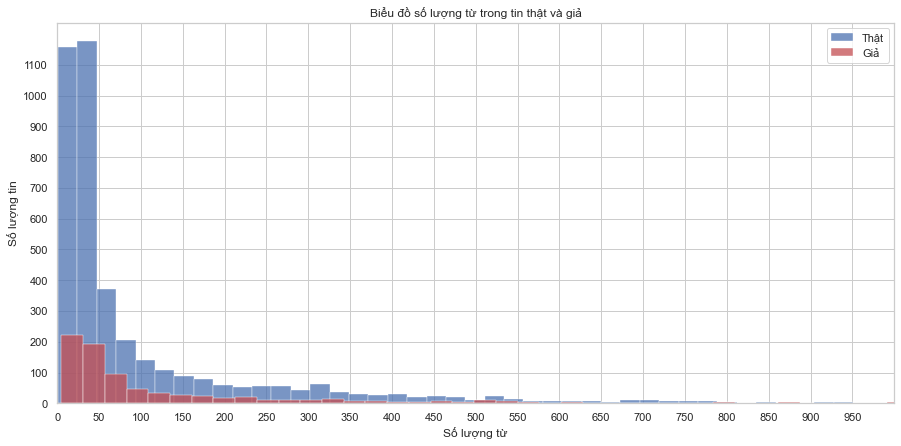

In [38]:
# for graphing
len_true = [len(n) for n in true_news]
len_fake = [len(n) for n in fake_news]

# Number of words distribution in fake and true news
plt.figure(figsize=(15, 7))
sns.histplot(data=len_true, bins=200, color='b')
sns.histplot(data=len_fake, bins=100, color='r')
plt.xticks(ticks=range(0, 1000, 50))
plt.yticks(ticks=range(0, 1200, 100))
plt.xlim(0,1000)
plt.xlabel('Số lượng từ')
plt.ylabel('Số lượng tin')
plt.legend(labels=["Thật", "Giả"])
plt.title('Biểu đồ số lượng từ trong tin thật và giả')

Text(0.5, 1.0, 'Biểu đồ số lượng tuơng tác trong tin thật và giả')

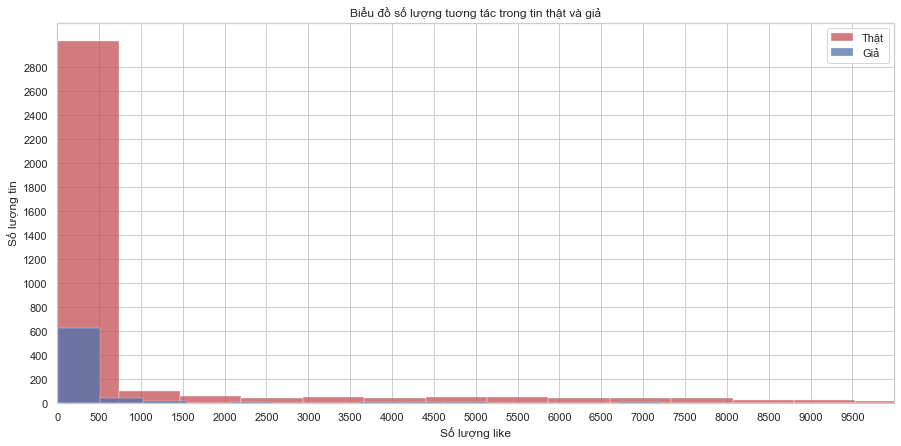

In [39]:
tt_true = [n for n in df[df['label'] == 0].iloc[:, [4, 5, 6]].sum(axis=1) if n<1000000000]
tt_fake = [n for n in df[df['label'] == 1].iloc[:, [4, 5, 6]].sum(axis=1) if n<1000000000]

# print(like_true)

plt.figure(figsize=(15, 7))

sns.histplot(data=tt_true, bins=200, color='r')
sns.histplot(data=tt_fake, bins=200, color='b')
plt.xticks(ticks=range(0, 10000, 500))
plt.yticks(ticks=range(0, 3000, 200))
plt.xlim(0,10000)
plt.xlabel('Số lượng like')
plt.ylabel('Số lượng tin')
plt.legend(labels=["Thật", "Giả"])
plt.title('Biểu đồ số lượng tuơng tác trong tin thật và giả')

Text(0.5, 1.0, 'Biểu đồ giờ được đăng của tin thật và giả')

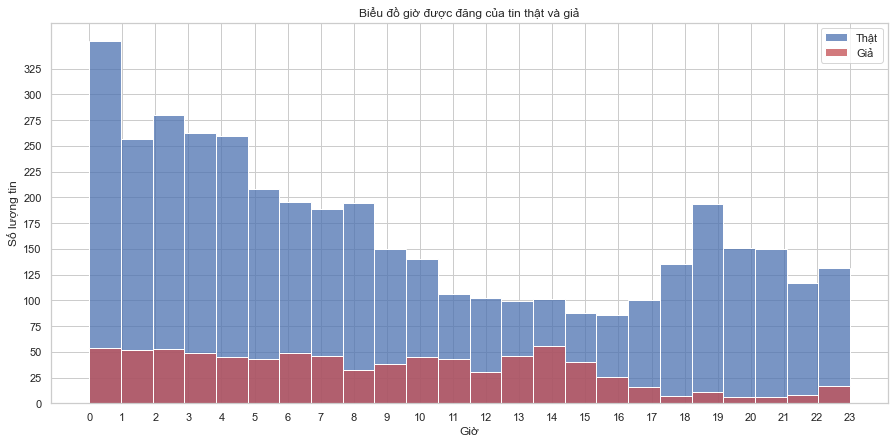

In [40]:
# for graphing
time_true = [n.hour for n in df[df['label'] == 0]['timestamp_post']]
time_fake = [n.hour for n in df[df['label'] == 1]['timestamp_post']]

plt.figure(figsize=(15, 7))
sns.histplot(data=time_true, bins=24, color='b')
sns.histplot(data=time_fake, bins=24, color='r')
plt.yticks(ticks=range(0, 350, 25))
plt.xticks(ticks=range(0, 24))
plt.xlabel('Giờ')
plt.ylabel('Số lượng tin')
plt.legend(labels=["Thật", "Giả"])
plt.title('Biểu đồ giờ được đăng của tin thật và giả')

Text(0.5, 1.0, 'Biểu đồ ngày được đăng của tin thật và giả')

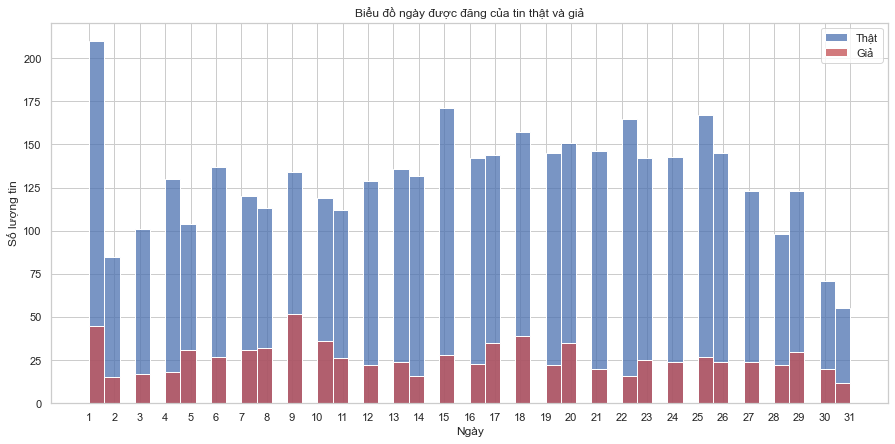

In [41]:
# for graphing
day_true = [n.day for n in df[df['label'] == 0]['timestamp_post']]
day_fake = [n.day for n in df[df['label'] == 1]['timestamp_post']]

plt.figure(figsize=(15, 7))
sns.histplot(data=day_true, bins=50, color='b')
sns.histplot(data=day_fake, bins=50, color='r')
#plt.yticks(ticks=range(0, 350, 25))
plt.xticks(ticks=range(1, 32))
plt.xlabel('Ngày')
plt.ylabel('Số lượng tin')
plt.legend(labels=["Thật", "Giả"])
plt.title('Biểu đồ ngày được đăng của tin thật và giả')

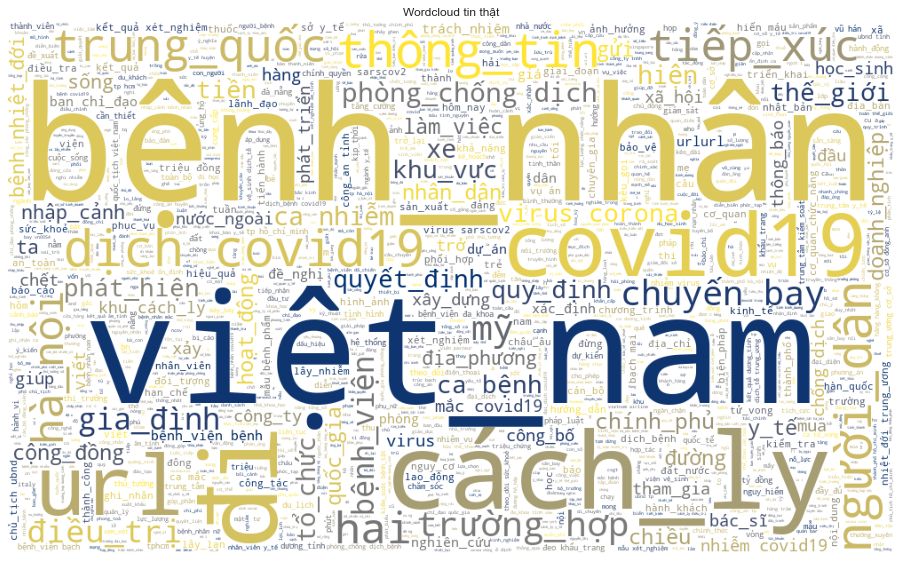

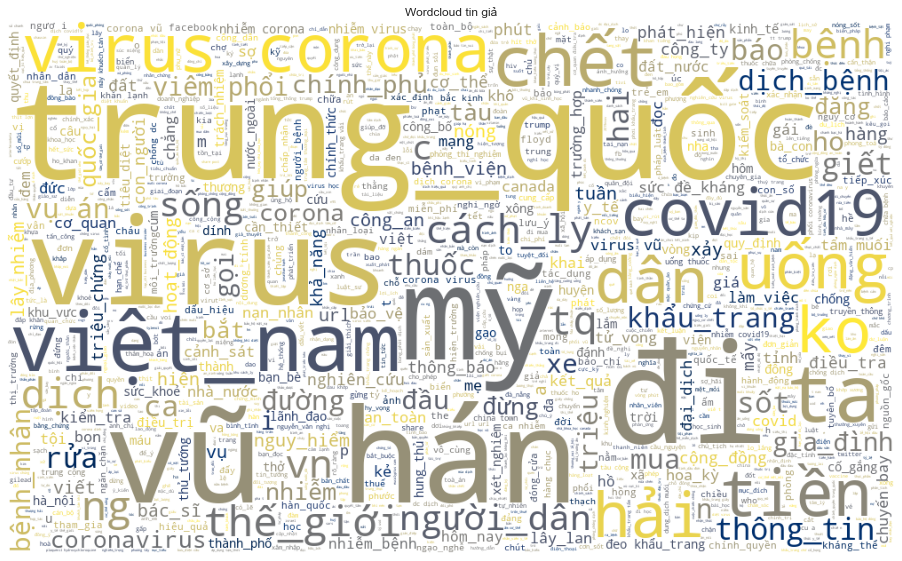

In [42]:
from wordcloud import WordCloud, ImageColorGenerator

# True news
true_news_flatten = list(itertools.chain(*true_news))

plt.figure(figsize = (35, 35))
wc1 = WordCloud(background_color='white', colormap='cividis_r', max_words = 2000, width = 1000, height = 600, stopwords = stopwords).generate(" ".join(true_news_flatten))
plt.subplot(1, 2, 1)
plt.title('Wordcloud tin thật')
plt.axis("off")
plt.imshow(wc1)

# Fake news
fake_news_flatten = list(itertools.chain(*fake_news))
plt.figure(figsize = (35, 35))
wc0 = WordCloud(background_color='white', colormap='cividis', max_words = 2000, width = 1000, height = 600, stopwords = stopwords).generate(" ".join(fake_news_flatten))
plt.subplot(1, 2, 2)
plt.title('Wordcloud tin giả')
plt.axis("off")
plt.imshow(wc0)